### <span style="color:red">Warning: Certain cells take upwards of 30 minutes to run!!!</span>
# <span style="font-size:1.3em;">Beer Me: A Content-Based Recommender System
Author: Steven Addison

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a> 
    
    - <a href="#Creating Final Database">Creating Final Database</a>
    
    - <a href="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a>    
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#Cosine Similarity">Cosine Similarity</a>
    
    - <a href="#Linear Kernal">Linear Kernal</a>
    
    - <a href="#K-Nearest Neighbors">K-Nearest Neighbors</a>
        
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

# <a id="#Overview">Overview</a>

> This project analyzes beer review data of 60,000 unique beers and recommends the top similar styles analyzing Review Text with a tf-idf vectorizer, Style, ABV, and Overall Rating.

# <a id="#Business Understanding">Business Understanding</a>

> As someone who has spent many years in the restaurant industry I often dread hearing “what do you recommend”, it always has felt like a loaded question to me seeing how one never has enough time to learn about a customer’s likes and taste in order to give accurate guidance. That is why a content-based recommender system such as this one can take all the guessing work out of the equation so that a customer can enjoy a beverage that has been selected for them based on similar items other enthusiasts have previously reviewed and enjoyed.

# <a id="Data Understanding">Data Understanding</a>

> For this project I used three datasets sourced from Kaggle that contains information gathered from Beer Advocate. For reproducibility one will have to download the data from the source, as it is too large to host on Github.

# <a id="Imports">Imports</a>

> First, I start with importing the relevant libraries needed to clean my data and create my models.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import texthero as hero
from texthero import preprocessing
from texthero.visualization import wordcloud


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

---
# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

> I wrote a simple function to explore my datasets with that can be found in the `eda.py` file in my repo. This function will display the first five rows of the dataframe, counts of the non-null values, data types, and total entires, check the descriptive statistics, value counts of every column, and print off the sum of any null values. This function is commented out in the notebook for brevity's sake, but can be accessed if cloned to your local machine. 

In [3]:
# import script used to preform basic EDA on my datasets, plus a dictionary used to define a later column
%run /content/eda.py

---
> ### First Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> This csv contains information about every beer on an individual level. Features such as `style`, `abv`, and `availability` will be used in the modeling process.

In [4]:
# Reading in the data containing the beers
beer = pd.read_csv('/content/drive/MyDrive/capstone/beers.csv')

In [5]:
# EDA on that data
eda(beer)

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358873 entries, 0 to 358872
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            358873 non-null  int64  
 1   name          358873 non-null  object 
 2   brewery_id    358873 non-null  int64  
 3   state         298147 non-null  object 
 4   country       358719 non-null  object 
 5   style         358872 non-null  object 
 6   availability  358873 non-null  object 
 7   abv           320076 non-null  float64
 8   notes         358827 non-null  object 
 9   retired       358873 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.4+ MB


None

,id,brewery_id,abv
count,358873.000000,358873.000000,320076.000000
mean,189241.027199,24597.365051,6.528504
std,107675.746916,16442.976904,2.085403
min,3.000000,1.000000,0.010000
25%,96422.000000,7318.000000,5.000000
50%,189909.000000,28383.000000,6.000000
75%,282546.000000,37452.000000,7.500000
max,374406.000000,54144.000000,100.000000




---- id ----
202522    1
355384    1
290114    1
170768    1
131404    1
         ..
62203     1
226884    1
289398    1
111993    1
267484    1
Name: id, Length: 358873, dtype: int64


---- name ----
Oktoberfest               755
IPA                       633
Pale Ale                  620
Hefeweizen                477
Oatmeal Stout             443
                         ... 
Debauched                   1
Black Hole Bock             1
Great White Hype IPA        1
Twisted Tale Cream Ale      1
Rumble Fish                 1
Name: name, Length: 298567, dtype: int64


---- brewery_id ----
1550     1229
28383    1225
17981    1043
1146      922
13307     898
         ... 
6816        1
33942       1
43031       1
54097       1
50238       1
Name: brewery_id, Length: 16569, dtype: int64


---- state ----
CA    33649
PA    17083
NY    14572
CO    14182
MI    12690
      ...  
MB      171
PE       98
YT       86
NL       77
NT        4
Name: state, Length: 67, dtype: int64


---- country 

id                  0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64

Total Null Count: 99724


In [6]:
# Dropping irrelevant columns
beer = beer.drop(columns=['country','notes'])

# Renaming columns for consistency among all dataframes
beer = beer.rename(columns={'id': 'beer_id', 'name': 'beer_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

# Cleaning the availability column 
beer['availability'] = beer['availability'].str.strip()

In [7]:
# Using the style dictionary to create the broad style column
beer['broad_style'] = beer['style'].replace(styledict)

---
> ### Second Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> Here we find information about the breweries. No data here will be used for modeling, however data about `state`,`city`, and `brewery_name` will be important elements to present in my results.

In [8]:
# Reading in the data containing the breweries
breweries = pd.read_csv('/content/drive/MyDrive/capstone/breweries.csv')

In [9]:
# EDA on that data
eda(breweries)

,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50347 entries, 0 to 50346
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50347 non-null  int64 
 1   name     50347 non-null  object
 2   city     50289 non-null  object
 3   state    39076 non-null  object
 4   country  50341 non-null  object
 5   notes    50262 non-null  object
 6   types    50347 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


None

,id
count,50347.000000
mean,27870.513874
std,15270.535930
min,1.000000
25%,15487.500000
50%,28313.000000
75%,40922.500000
max,54156.000000




---- id ----
19730    1
10604    1
44922    1
36965    1
40086    1
        ..
15647    1
6229     1
4403     1
7330     1
13986    1
Name: id, Length: 50347, dtype: int64


---- name ----
Whole Foods Market                   162
Total Wine & More                    147
Cost Plus World Market               118
Mellow Mushroom                      114
Trader Joe's                          88
                                    ... 
Jose O'Brien                           1
Jergensen`s Brewery                    1
Co-op Wines & Spirits - Creekside      1
Riverwalk Brewing                      1
Landmark Beer Company                  1
Name: name, Length: 45245, dtype: int64


---- city ----
Chicago             512
Philadelphia        505
New York            432
Portland            370
London              358
                   ... 
Zapfendorf            1
Droitwich             1
Folles                1
Lighthouse Point      1
Blagodarny            1
Name: city, Length: 11664, dtype: int

id             0
name           0
city          58
state      11271
country        6
notes         85
types          0
dtype: int64

Total Null Count: 11420


In [10]:
# Dropping irrelevant columns
breweries = breweries.drop(columns=['notes'])

# Renaming columns for consistency among all dataframes
breweries = breweries.rename(columns={'id': 'brewery_id', 'name': 'brewery_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

---
> ### Third Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> Finally, I load in my review data. This will provide my most important modeling feature.

In [11]:
# Reading in the data containg the breweries
reviews = pd.read_csv('/content/drive/MyDrive/capstone/reviews.csv')

In [12]:
# EDA on that data
eda(reviews)

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   date      object 
 3   text      object 
 4   look      float64
 5   smell     float64
 6   taste     float64
 7   feel      float64
 8   overall   float64
 9   score     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 692.2+ MB


None

,beer_id,look,smell,taste,feel,overall,score
count,9.073128e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,9.073128e+06
mean,7.730655e+04,3.952155e+00,3.887863e+00,3.920704e+00,3.884350e+00,3.916280e+00,3.889815e+00
std,7.929345e+04,5.517191e-01,6.115910e-01,6.333365e-01,5.999279e-01,6.054554e-01,6.127417e-01
min,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.155400e+04,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.570000e+00
50%,5.654500e+04,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,1.076670e+05,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,3.731280e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00




---- beer_id ----
11757     17160
2093      15947
7971      14927
1093      14915
29619     14292
          ...  
236106        1
255323        1
241504        1
178241        1
48151         1
Name: beer_id, Length: 309542, dtype: int64


---- username ----
Sammy            13798
kylehay2004      12221
acurtis          12016
StonedTrippin    11859
jaydoc           11800
                 ...  
perlburglar          1
Smash_shley          1
theHarv              1
Paulgifford          1
jwaterworth          1
Name: username, Length: 164934, dtype: int64


---- date ----
2011-11-15    17648
2011-11-14    17010
2011-11-16     9571
2014-07-20     9066
2011-11-18     8739
              ...  
1999-03-22        1
1998-10-13        1
1999-03-08        1
1999-01-14        1
1998-02-06        1
Name: date, Length: 6560, dtype: int64


---- text ----
                                                                                                                                                    

beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64

Total Null Count: 18953905


In [13]:
# Dropping irrelevant columns
reviews = reviews.drop(columns=['date','look','smell','taste','feel','overall'])

# Setting blank reviews as nan so they can be dropped
reviews['text'] = reviews['text'].str.strip()
reviews['text'] = reviews['text'].replace({"":np.nan,"0%":np.nan})

# Dropping reviews without username and review text data
reviews = reviews.dropna(subset=['username','text'])

---

## <a id="#Creating Final Database">Creating Final Database</a>
> Now that all my data is loaded and cleaned, it can be combined. Using `id` columns provided in each dataframe this does not prove to be too much of a hassle. Once merged I can then group every unique beer and conglomerate all of their reviews into individual documents. 

In [14]:
# Merging reviews into the beers bases on beer id
beer_reviews = beer.merge(reviews, on=['beer_id'])

In [15]:
# Merging breweries into the combined data
plus_brew = beer_reviews.merge(breweries, on=['brewery_id'])

In [16]:
# Dropping duplicate column
plus_brew = plus_brew.drop(columns=['state_x'])

# Renaming column to reflect
plus_brew = plus_brew.rename(columns={'state_y': 'state'})

In [17]:
# Selecting only available US beers
df = plus_brew.loc[(plus_brew['country'] == 'US') & (plus_brew['retired'] == 'f')]

# Dropping duplicates
df = df.drop_duplicates()

# Dropping rows with missing ibu data 
df = df.dropna(subset=['abv'])

# Sanity check of the data
df.head()

,beer_id,beer_name,brewery_id,style,availability,abv,retired,broad_style,username,text,score,brewery_name,city,state,country,types
0,246438,Peaches-N-Cream,44617,American Cream Ale,Rotating,5.1,f,Hybrid Beer,rolltide8425,Exactly what it says it is,3.67,Mad Princes Brewing,Doylestown,PA,US,"Brewery, Bar, Beer-to-go"
1,246443,Clinging And Bitter,44617,English Bitter,Rotating,3.8,f,Pale Ale,rolltide8425,A no-nonsense British style bitter; just how I...,3.74,Mad Princes Brewing,Doylestown,PA,US,"Brewery, Bar, Beer-to-go"
433,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,DrMullet,Pours a very dark brown with moderate head and...,3.50,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"
434,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,Karibourgeois,Dark brown pour with a tan head. Aroma of choc...,3.44,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"
435,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,Jeffsta1,"Beautiful dark brown/black, with a pretty, pal...",3.44,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"


In [18]:
# Checking to see if some of these beers are actually named IPA and looking at each brewery's website I can confirm they are not creative people
df.loc[df['beer_name'] == 'IPA']

,beer_id,beer_name,brewery_id,style,availability,abv,retired,broad_style,username,text,score,brewery_name,city,state,country,types
106363,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,mjbachma,"Classic bottle and labeling, titled by style, ...",3.94,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
106364,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,CraftBeerRunner,Sweet Jammy fruity and bright. Drank fresh whi...,4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
106365,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,Hopheadjeffery,Tasted in a Spiegelau IPA glass from a bottle ...,4.04,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
106366,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,BeerAndGasMasks,"From the bottle, it pours a nice lightly hazy ...",4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
106367,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,NickSMpls,Can these guys do anything that's not great? O...,4.18,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429005,138894,IPA,36717,American IPA,Year-round,6.0,f,India Pale Ale,JonAdams,"Poured from tap at brewery. Deep copper, clear...",4.30,Lizard Tail Brewing,Albuquerque,NM,US,"Brewery, Bar, Beer-to-go"
2429495,322903,IPA,47202,American IPA,Year-round,5.9,f,India Pale Ale,stevoj,Bottle from BevMo. Gusher at opening. Dark gol...,3.55,Dagny Brewing Company,Modesto,CA,US,Brewery
2429694,275547,IPA,48593,American IPA,Year-round,6.6,f,India Pale Ale,JacobusFavier23,L- Straw colored IPA with a slight amber tint....,3.66,Haint Blue Brewery,Mobile,AL,US,Brewery
2429712,349972,IPA,49155,American IPA,Year-round,6.5,f,India Pale Ale,brett808ola,"Smells very fruity, great for tropical weather...",4.98,Hawaiian Ola Brewing Corporation,Kailua Kona,HI,US,"Brewery, Bar, Beer-to-go"


In [19]:
# Creating a dataframe grouped by beer for content-based recommendations
cont_df = df.groupby(['beer_id'], as_index = False).agg({'text':' '.join, 'score':'mean','beer_id':'first',
                                                         'beer_name':'first','style':'first','broad_style':'first',
                                                         'abv':'first','brewery_name':'first','city':'first',
                                                         'state':'first'})

# Setting the index to beer's unique ID
cont_df = cont_df.set_index('beer_id')

# Sanity check of the data
cont_df.head()

,text,score,beer_name,style,broad_style,abv,brewery_name,city,state
beer_id,,,,,,,,,
5,Beautiful beer. Light and tasty. I travel all ...,3.396390,Amber,Vienna Lager,Dark Lager,4.5,Abita Brewing Co.,Abita Springs,LA
6,great brown ale...one of my favorites. Might h...,3.646446,Turbodog,English Brown Ale,Brown Ale,5.6,Abita Brewing Co.,Abita Springs,LA
7,The labeling with the purple haze guy with the...,3.243842,Purple Haze,Fruit and Field Beer,Specialty Beer,4.2,Abita Brewing Co.,Abita Springs,LA
9,Poured chilled in large glass stein. A: cloudy...,3.087823,Golden,American Lager,Pale Lager,4.2,Abita Brewing Co.,Abita Springs,LA
10,Pours slightly hazy deep amber/brown. 1 finger...,3.794484,Dubbel Ale,Belgian Dubbel,Dark Ale,7.0,Allagash Brewing Company,Portland,ME


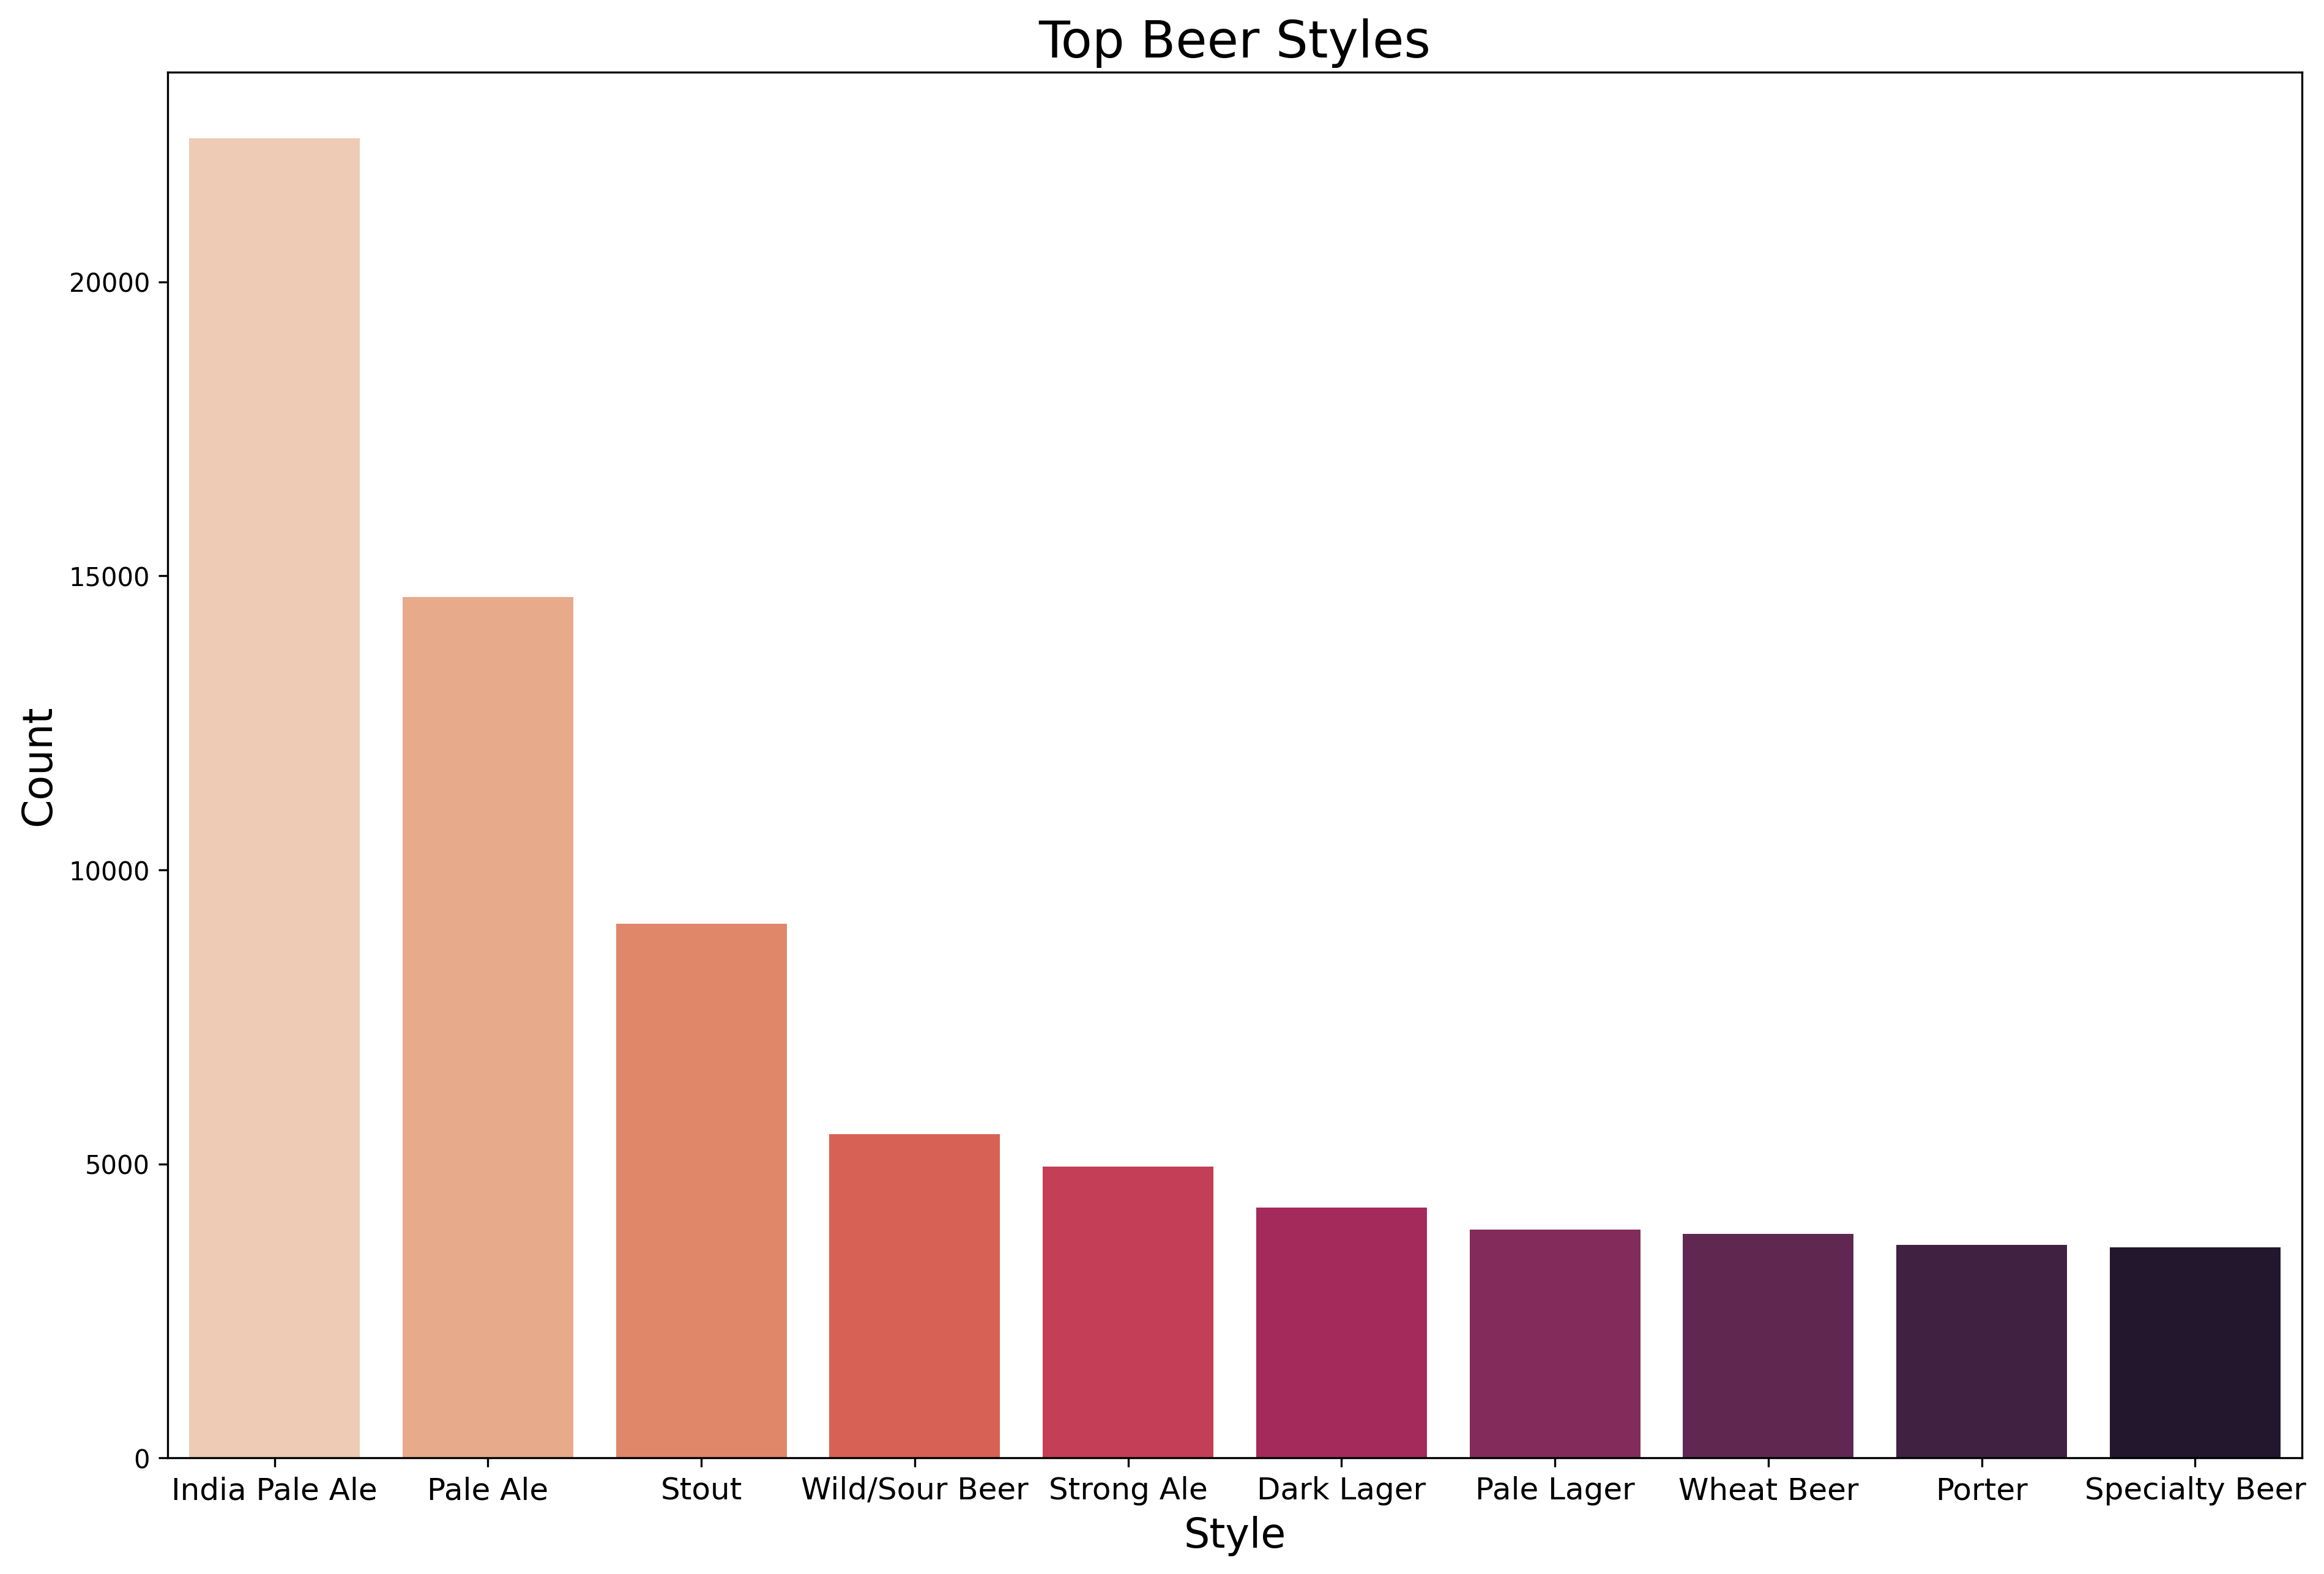

In [20]:
# Plotting the top ten styles
plt.figure(figsize=(15,10), dpi=300)
ax = sns.countplot(x = 'broad_style', data=cont_df, palette='rocket_r', 
                   order=cont_df['broad_style'].value_counts().index[:10])
plt.title("Top Beer Styles", fontsize=20)
plt.xlabel("Style", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12);

## <a id="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a> 

> Knowing I wanted to use NLP in my project, I set out to do some research. After reading [several](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db) [different](https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272) [articles](https://elitedatascience.com/python-nlp-libraries) on how to clean and analyze text data I decided to use [Texthero](https://texthero.org/) for my review preprocessing. Combining elements of spaCy and NLTK, along with its simple to use all-in-one cleaning pipeline, it provided to be the most logical choice of tool. [documentation](https://texthero.org/docs/api-preprocessing) can be found here.
> 
> Then the cleaned text data is vectorized using tf–idf to create a document-term matrix. After several iterations of testing different combinations I find that using 300 features with a range of unigrams to trigrams provided the best results in the models.

In [21]:
# Using Texthero's built in text cleaning pipeline
cont_df['clean_text'] = hero.clean(cont_df['text'])

In [22]:
# Stemming the text for modeling
cont_df['clean_text'] = hero.stem(cont_df['clean_text'])

In [23]:
# Dropping irelevant columns 
cont_df = cont_df.drop(columns=['text'])

In [24]:
# Sanity check of the data
cont_df.head()

,score,beer_name,style,broad_style,abv,brewery_name,city,state,clean_text
beer_id,,,,,,,,,
5,3.396390,Amber,Vienna Lager,Dark Lager,4.5,Abita Brewing Co.,Abita Springs,LA,beauti beer light tasti travel world tri drink...
6,3.646446,Turbodog,English Brown Ale,Brown Ale,5.6,Abita Brewing Co.,Abita Springs,LA,great brown ale one favorit might bad bottl on...
7,3.243842,Purple Haze,Fruit and Field Beer,Specialty Beer,4.2,Abita Brewing Co.,Abita Springs,LA,label purpl haze guy face paint look awesom un...
9,3.087823,Golden,American Lager,Pale Lager,4.2,Abita Brewing Co.,Abita Springs,LA,pour chill larg glass stein cloudi golden yell...
10,3.794484,Dubbel Ale,Belgian Dubbel,Dark Ale,7.0,Allagash Brewing Company,Portland,ME,pour slight hazi deep amber brown finger head ...


In [25]:
# Saving off final cleaned dataset for use in the Streamlit App
# cont_df.to_csv('data/cont_df.csv', index_label = 'beer_id')

In [26]:
pale_df = cont_df[cont_df['broad_style'] == 'Pale Ale']

In [27]:
# Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))

# Fitting and transforming the clean text data 
dtm = tf.fit_transform(pale_df['clean_text'])

# Creating a document-term matrix
dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = pale_df.index)

In [28]:
# Sanity check of the data
dtm.head()

,12oz,abv,aftertast,alcohol,ale,almost,along,also,amber,amber color,american,amount,anoth,apa,appear,appl,aroma,around,averag,back,bad,balanc,banana,beer,beer pour,belgian,best,better,big,biscuit,bit,bite,bitter,bodi,bottl,bottl pour,bread,breadi,breadi malt,brett,...,sweet,sweet malt,take,tap,tart,tast,tasti,thank,thick,thin,thing,think,though,time,toast,tongu,top,touch,tri,tropic,tulip,two,want,warm,wateri,way,well,well balanc,wheat,white,white head,wine,work,worth,would,yeast,yeasti,yellow,yet,zest
beer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,0.048831,0.007315,0.064122,0.015552,0.098449,0.033760,0.031388,0.020454,0.238488,0.121319,0.000000,0.021019,0.007909,0.000000,0.045102,0.040205,0.135720,0.014178,0.061943,0.042309,0.037096,0.034001,0.000000,0.166943,0.032643,0.000000,0.015312,0.042990,0.035115,0.007890,0.125417,0.016223,0.051046,0.109099,0.112367,0.009484,0.036618,0.087007,0.008402,0.000000,...,0.184225,0.040316,0.000000,0.022642,0.007383,0.172032,0.029208,0.034796,0.050195,0.043061,0.000000,0.014430,0.021559,0.014557,0.038125,0.008015,0.029039,0.058964,0.039892,0.000000,0.016185,0.015394,0.008284,0.007584,0.042939,0.020826,0.084511,0.000000,0.023572,0.086084,0.063086,0.000000,0.016056,0.015966,0.073489,0.018034,0.008167,0.012348,0.000000,0.000000
39,0.036066,0.019789,0.032889,0.034727,0.125156,0.039576,0.021228,0.042306,0.111033,0.048449,0.033107,0.038510,0.026490,0.117440,0.038043,0.006388,0.085727,0.038964,0.014463,0.045419,0.012425,0.133960,0.002234,0.214885,0.021552,0.001203,0.035177,0.023844,0.060465,0.014060,0.073938,0.028737,0.144869,0.081263,0.131183,0.028507,0.015724,0.023854,0.013530,0.000000,...,0.135193,0.036183,0.023085,0.020660,0.006023,0.133828,0.020851,0.052856,0.045418,0.027868,0.020713,0.032531,0.031939,0.049695,0.016699,0.028737,0.035694,0.023210,0.042397,0.019083,0.015464,0.031730,0.024013,0.020028,0.004056,0.037411,0.108188,0.041603,0.003543,0.069125,0.056471,0.002702,0.009307,0.011826,0.060615,0.006970,0.001227,0.002916,0.023410,0.011894
69,0.032166,0.025813,0.051960,0.016465,0.124338,0.063538,0.007384,0.032080,0.029529,0.003805,0.013089,0.026373,0.016746,0.000000,0.048506,0.011350,0.110207,0.018345,0.043718,0.026542,0.062835,0.055994,0.017799,0.260553,0.044158,0.001883,0.009006,0.050568,0.026435,0.025986,0.118021,0.028625,0.067687,0.091806,0.114002,0.024543,0.027567,0.020469,0.007907,0.000000,...,0.165582,0.053115,0.014664,0.015980,0.006947,0.180711,0.029203,0.006139,0.015183,0.076702,0.018157,0.027158,0.027051,0.027398,0.025114,0.022626,0.029035,0.067817,0.034411,0.000000,0.001904,0.016297,0.009745,0.026762,0.044447,0.037563,0.082012,0.017994,0.120153,0.107335,0.090190,0.006344,0.013220,0.013146,0.074918,0.024042,0.015370,0.071172,0.026799,0.013822
93,0.000000,0.012291,0.035916,0.004900,0.151279,0.053891,0.021426,0.047259,0.019773,0.010193,0.031720,0.027961,0.008306,0.067143,0.039247,0.033779,0.091957,0.032758,0.042285,0.025179,0.046750,0.094032,0.007946,0.235192,0.020569,0.003363,0.049850,0.031604,0.011801,0.043087,0.109761,0.030668,0.081876,0.089017,0.066380,0.007968,0.055377,0.044985,0.014118,0.000000,...,0.128983,0.035566,0.016365,0.048746,0.007753,0.164703,0.018404,0.018271,0.027111,0.067189,0.021074,0.040917,0.042265,0.019875,0.036836,0.028618,0.022873,0.042659,0.047481,0.001729,0.000000,0.025867,0.006960,0.022301,0.018038,0.055409,0.092082,0.028561,0.049511,0.104871,0.084600,0.000000,0.016862,0.026828,0.084896,0.055556,0.029161,0.084292,0.015381,0.007052
141,0.020572,0.039601,0.034504,0.127519,0.035192,0.041870,0.025334,0.047381,0.011614,0.002866,0.020029,0.029379,0.026313,0.000000,0.052132,0.071551,0.082051,0.032936,0.008079,0.032483,0.014167,0.057007,0.121759,0.227489,0.022492,0.127800,0.040844,0.025671,0.051016,0.008387,0.095468,0.024752,0.056823,0.073684,0.167427,0.028939,0.025375,0.028459,0.006451,0.005363,...,0.127679,0.016191,0.024848,0.014152,0.070633,0.167679,0.019837,0.008391,0.057313,0.022041,0.021271,0.034230,0.032115,0.054593,0.

# <a href="#Modeling">Modeling</a>
> To prepare my data to be modeled I use one-hot encoding and min-max scaling on my numerical features, and join them back into my document-term matrix that I created above. I then test out a Cosine Similarity method, first creating it step by step, then in a function that can be used with user inputs. Once I create that function I am able to easily tailor it to other content-based modeling methods like Linear Kernel Method and K-Nearest Neighbors.

In [29]:
# Merging the document-term matrix back into the style dataframe
model_df = pale_df.merge(dtm, left_index=True, right_index=True)

# Renaming columns with the same name
model_df = model_df.rename(columns={'style_x':'style','abv_x':'abv'})

# Dropping irrelevant columns
model_df = model_df.drop(columns=['style','beer_name','brewery_name','city','state','clean_text'])

In [30]:
# Creating a dataframe to call my results from
result_df = cont_df[['beer_name','style','brewery_name','city','state']]

# Making the column names pretty
result_df = result_df.rename(columns={'beer_name':'Name','style':'Style',
                                      'brewery_name':'Brewery','city':'City',
                                      'state':'State'})

In [31]:
# Encoding the styles for modeling
style_OHE = pd.get_dummies(model_df['broad_style'], sparse=True)

In [32]:
# Calling the columns that need to be scaled
col_names = ['abv', 'score']

# Selecting those columns
features = model_df[col_names]

# Fitting and transforming the columns with a MinMaxScalers
features = MinMaxScaler().fit_transform(features.values)

# Setting those transformed features back into the data
model_df[col_names] = features

# Joining the one hot encoded data with the scaled data
final_df = model_df.join(style_OHE)

# Dropping the style column now that it is encoded out
final_df = final_df.drop(columns=['broad_style'])

In [33]:
# Sanity check
final_df.head()

,score,abv,12oz,abv_y,aftertast,alcohol,ale,almost,along,also,amber,amber color,american,amount,anoth,apa,appear,appl,aroma,around,averag,back,bad,balanc,banana,beer,beer pour,belgian,best,better,big,biscuit,bit,bite,bitter,bodi,bottl,bottl pour,bread,breadi,...,sweet malt,take,tap,tart,tast,tasti,thank,thick,thin,thing,think,though,time,toast,tongu,top,touch,tri,tropic,tulip,two,want,warm,wateri,way,well,well balanc,wheat,white,white head,wine,work,worth,would,yeast,yeasti,yellow,yet,zest,Pale Ale
beer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,0.599082,0.254545,0.048831,0.007315,0.064122,0.015552,0.098449,0.033760,0.031388,0.020454,0.238488,0.121319,0.000000,0.021019,0.007909,0.000000,0.045102,0.040205,0.135720,0.014178,0.061943,0.042309,0.037096,0.034001,0.000000,0.166943,0.032643,0.000000,0.015312,0.042990,0.035115,0.007890,0.125417,0.016223,0.051046,0.109099,0.112367,0.009484,0.036618,0.087007,...,0.040316,0.000000,0.022642,0.007383,0.172032,0.029208,0.034796,0.050195,0.043061,0.000000,0.014430,0.021559,0.014557,0.038125,0.008015,0.029039,0.058964,0.039892,0.000000,0.016185,0.015394,0.008284,0.007584,0.042939,0.020826,0.084511,0.000000,0.023572,0.086084,0.063086,0.000000,0.016056,0.015966,0.073489,0.018034,0.008167,0.012348,0.000000,0.000000,1
39,0.816956,0.423636,0.036066,0.019789,0.032889,0.034727,0.125156,0.039576,0.021228,0.042306,0.111033,0.048449,0.033107,0.038510,0.026490,0.117440,0.038043,0.006388,0.085727,0.038964,0.014463,0.045419,0.012425,0.133960,0.002234,0.214885,0.021552,0.001203,0.035177,0.023844,0.060465,0.014060,0.073938,0.028737,0.144869,0.081263,0.131183,0.028507,0.015724,0.023854,...,0.036183,0.023085,0.020660,0.006023,0.133828,0.020851,0.052856,0.045418,0.027868,0.020713,0.032531,0.031939,0.049695,0.016699,0.028737,0.035694,0.023210,0.042397,0.019083,0.015464,0.031730,0.024013,0.020028,0.004056,0.037411,0.108188,0.041603,0.003543,0.069125,0.056471,0.002702,0.009307,0.011826,0.060615,0.006970,0.001227,0.002916,0.023410,0.011894,1
69,0.580142,0.300000,0.032166,0.025813,0.051960,0.016465,0.124338,0.063538,0.007384,0.032080,0.029529,0.003805,0.013089,0.026373,0.016746,0.000000,0.048506,0.011350,0.110207,0.018345,0.043718,0.026542,0.062835,0.055994,0.017799,0.260553,0.044158,0.001883,0.009006,0.050568,0.026435,0.025986,0.118021,0.028625,0.067687,0.091806,0.114002,0.024543,0.027567,0.020469,...,0.053115,0.014664,0.015980,0.006947,0.180711,0.029203,0.006139,0.015183,0.076702,0.018157,0.027158,0.027051,0.027398,0.025114,0.022626,0.029035,0.067817,0.034411,0.000000,0.001904,0.016297,0.009745,0.026762,0.044447,0.037563,0.082012,0.017994,0.120153,0.107335,0.090190,0.006344,0.013220,0.013146,0.074918,0.024042,0.015370,0.071172,0.026799,0.013822,1
93,0.641435,0.300000,0.000000,0.012291,0.035916,0.004900,0.151279,0.053891,0.021426,0.047259,0.019773,0.010193,0.031720,0.027961,0.008306,0.067143,0.039247,0.033779,0.091957,0.032758,0.042285,0.025179,0.046750,0.094032,0.007946,0.235192,0.020569,0.003363,0.049850,0.031604,0.011801,0.043087,0.109761,0.030668,0.081876,0.089017,0.066380,0.007968,0.055377,0.044985,...,0.035566,0.016365,0.048746,0.007753,0.164703,0.018404,0.018271,0.027111,0.067189,0.021074,0.040917,0.042265,0.019875,0.036836,0.028618,0.022873,0.042659,0.047481,0.001729,0.000000,0.025867,0.006960,0.022301,0.018038,0.055409,0.092082,0.028561,0.049511,0.104871,0.084600,0.000000,0.016862,0.026828,0.084896,0.055556,0.029161,0.084292,0.015381,0.007052,1
141,0.793341,0.518182,0.020572,0.039601,0.034504,0.127519,0.035192,0.041870,0.025334,0.047381,0.011614,0.002866,0.020029,0.029379,0.026313,0.000000,0.052132,0.071551,0.082051,0.032936,0.008079,0.032483,0.014167,0.057007,0.121759,0.227489,0.022492,0.127800,0.040844,0.025671,0.051016,0.008387,0.095468,0.024752,0.056823,0.073684,0.167427,0.028939,0.025375,0.028459,...,0.016191,0.024848,0.014152,0.070633,0.167679,0.019837,0.008391,0.057313,0.022041,0.021271,0.034230,0.032115,0.054593,0.004203,0.040707,0.031585,0.030180,0.0437

In [34]:
# Superfuzz is the beer I will be testing
y = np.array(final_df.loc[90993])

# Reshaping the row into an array that can be passed into the model
y = y.reshape(1, -1)

# Calculating the cosine similarity 
cos_sim = cosine_similarity(final_df, y)

# Creating a printout of the scores with their respective indices
cos_sim = pd.DataFrame(data=cos_sim, index=final_df.index)

# Sorting by highest scoring
results = cos_sim.sort_values(by = 0, ascending=False)

# Printing out the source beer and its top 5 recommendations
results.head(6)

,0
beer_id,
90993,1.000000
259486,0.985669
175577,0.979440
80348,0.975831
280196,0.970518
58206,0.965070


In [35]:
# This is the printout for my starting beer
result_df.loc[90993]

Name       Superfuzz Blood Orange Pale Ale
Style              American Pale Ale (APA)
Brewery            Elysian Brewing Company
City                               Seattle
State                                   WA
Name: 90993, dtype: object

In [36]:
# And the printout of my top result
result_df.loc[259486]

Name         Sidecar Orange Pale Ale
Style        American Pale Ale (APA)
Brewery    Sierra Nevada Brewing Co.
City                           Chico
State                             CA
Name: 259486, dtype: object

## <a id="#Cosine Similarity">Cosine Similarity</a>

In [37]:
def cos_beer():
    
    """Returns top recommended beers based on cosine similarity with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the cosine similarity 
    cos_sim = cosine_similarity(style_df, y)
    # Creating a printout of the scores with their respective indices
    cos_sim = pd.DataFrame(data=cos_sim, index=style_df.index)
    # Sorting by highest scoring
    results = cos_sim.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [38]:
# Testing the function
cos_beer()

Style: Pale Ale
Beer Name: Superfuzz Blood Orange Pale Ale
How many recommendations? 5


Name,Style,Brewery,City,State
Sidecar Orange Pale Ale,American Pale Ale (APA),Sierra Nevada Brewing Co.,Chico,CA
CitruSinensis (OneHitter Series),American Pale Ale (APA),Lagunitas Brewing Company,Petaluma,CA
Blood Orange Pale Ale,American Pale Ale (APA),Great South Bay Brewery,Bay Shore,NY
X - Orange,American Pale Ale (APA),AleSmith Brewing Company,San Diego,CA
Naranjito,American Pale Ale (APA),Brooklyn Brewery,Brooklyn,NY


## <a id="#Linear Kernal">Linear Kernal</a>

In [39]:
def lin_beer():
    
    """Returns top recommended beers based on linear kernel method with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the linear kernel 
    lin_ker = linear_kernel(style_df, y)
    # Creating a printout of the scores with their respective indices
    lin_ker = pd.DataFrame(data=lin_ker, index=style_df.index)
    # Sorting by highest scoring
    results = lin_ker.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [40]:
# Testing the function
lin_beer()

Style: Pale Ale
Beer Name: Superfuzz Blood Orange Pale Ale
How many recommendations? 5


Name,Style,Brewery,City,State
Superfuzz Blood Orange Pale Ale,American Pale Ale (APA),Elysian Brewing Company,Seattle,WA
Mosaic Dry Hopped Fort Point,American Pale Ale (APA),Trillium Brewing Company,Boston,MA
Galaxy Dry Hopped Fort Point Pale Ale,American Pale Ale (APA),Trillium Brewing Company,Boston,MA
Pseudo Sue - Double Dry-Hopped,American Pale Ale (APA),Toppling Goliath Brewing Company,Decorah,IA
Double Dry Hopped Fort Point Pale Ale,American Pale Ale (APA),Trillium Brewing Company,Boston,MA


## <a id="#K-Nearest Neighbors">K-Nearest Neighbors</a>

In [41]:
def knn_beer():
    
    """Returns top recommended beers using K-Nearest Neighbors with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style_x','style_y','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    x = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    x = y.reshape(1, -1)
    
    # Creating a knn model with the auto algorithm and 5 nearest neighbors
    knn = NearestNeighbors(algorithm='auto', n_neighbors=5)
    # Fitting the model on the dataframe
    knn.fit(style_df)
    
    # Selecting n number results
    results = knn.kneighbors(x, n_recs+1, return_distance=False).flatten()
    # Selecting their indicies
    resultsids = style_df.iloc[results].index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[resultsids]
    # Returning those results
    return nresults_df.style.hide_index()

In [42]:
# # Testing the function
# knn_beer()

# <a id="#Conclusion">Conclusion</a>

> After reading [articles](https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a) on the subject of how to best determine what method to use, I decided upon my Cosine Similarity model. It is widely used for caluclating text data similarity, therefore the best approach for handling my review data. From the function I created here I built an app using `Streamlit`, deployed on [Heroku](https://beer-me-recommender.herokuapp.com/). With Heroku's limited virtual memory allocation being my main hurdle I found it best to create a document-term matrix for all fourteen broad styles outside of the app and have them read in determined by a user's input. This keeps the load times quick and the memory usage as low as possilbe. Ideally, I would want to see this implemented by a beer review website such as Beer Advocate or Ratebeer. They already have all the data necessary, and could create this app to be then sold to businesses to so that they can make accurate data based recommendations to their customers.
>
> Lastly here, I wanted to create a few images to use for my presentation based on my reference beer and top recommendation.
> Gaining inspiration from [this article](https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214) I was able to use `text hero` once more to create these word clouds.

In [43]:
# Importing mask for the shape of my word clouds
beer_mask = np.array(Image.open('images/beershape.png'))

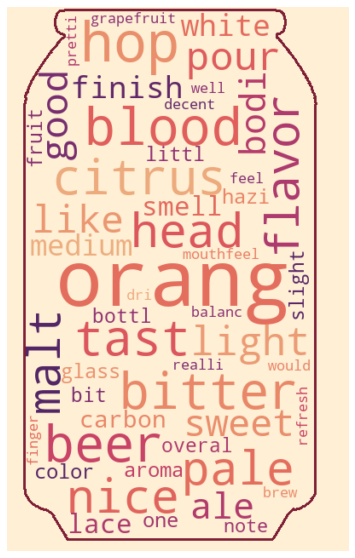

In [44]:
# Creating cloud for my reference beer
beer1 = cont_df.loc[[90993]]['clean_text']
wordcloud(beer1, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

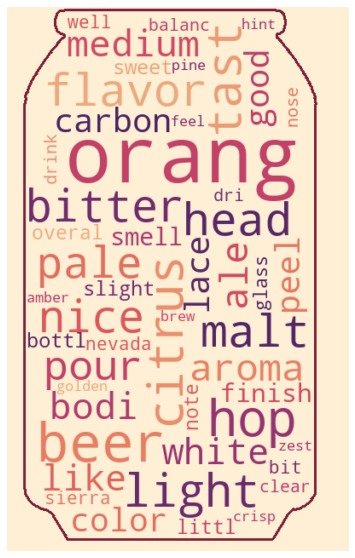

In [45]:
# Creating cloud for my top recommendation
beer2 = cont_df.loc[[259486]]['clean_text']
wordcloud(beer2, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

# <a id="#Next Steps">Next Steps</a>   

> As extensive as this may seem, there is always more data that can be gathered. Ideally I would like to get more current data for as many beers as possible to keep the model as up to date as possible. I would also be interested in gathering more features to use such as IBU, and the varieties of hops and malts used to brew each beer. In addition to that, I would like to create more specific data slicing options in the app such as being able to get recommendations based on state or even a brewery level. Lastly I would want to implement this model for other consumables such as whole bean coffee or wine, if you can review it, I can use it!

# <a id="#Sources">Sources</a>

> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
>[How to Vectorize Text in DataFrames for NLP Tasks — 3 Simple Techniques](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db)
>
> [Try TextHero: The Absolute Simplest way to Clean and Analyze Text in Pandas](https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272)
>
> [5 Heroic Python NLP Libraries](https://elitedatascience.com/python-nlp-libraries)
>
> [Texthero](https://texthero.org/)
>
> [Understanding Cosine Similarity And Its Application](https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a)
>
> [How to Create Beautiful Word Clouds in Python](https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214)